In [30]:
%matplotlib inline

In [37]:
import matplotlib.pyplot

import keras_rcnn.datasets.pascal
import keras_rcnn.preprocessing

In [32]:
# -*- coding: utf-8 -*-

import keras.backend
import keras.preprocessing.image
import numpy
import skimage.io
import skimage.transform


def scale_size(size, min_size, max_size):
    """
    Rescales a given image size such that the larger axis is
    no larger than max_size and the smallest axis is as close
    as possible to min_size.
    """
    assert (len(size) == 2)

    scale = min_size / numpy.min(size)

    # Prevent the biggest axis from being larger than max_size.
    if numpy.round(scale * numpy.max(size)) > max_size:
        scale = max_size / numpy.max(size)

    rows, cols = size
    rows *= scale
    cols *= scale

    return (int(rows), int(cols)), scale


class DictionaryIterator(keras.preprocessing.image.Iterator):
    def __init__(
            self,
            dictionary,
            classes,
            target_shape,
            scale,
            ox,
            oy,
            generator,
            batch_size=1,
            shuffle=False,
            seed=None
    ):
        self.batch_size = batch_size

        self.dictionary = dictionary
        self.classes = classes
        self.generator = generator

        assert (len(self.dictionary) != 0)

        rows, cols, channels = dictionary[0]["shape"]
        self.image_shape = (rows, cols, channels)
        self.scale = scale
        self.ox = ox
        self.oy = oy
        if target_shape is None:
            self.target_shape, self.scale = scale_size(self.image_shape[0:2], numpy.min(self.image_shape[:2]), numpy.max(self.image_shape[:2]))

            self.target_shape = self.target_shape + (self.image_shape[2],)

        else:
            self.target_shape = target_shape + (self.image_shape[2],)

        # Metadata needs to be computed only once.
        rows, cols, channels = self.target_shape

        self.metadata = numpy.array([[rows, cols, self.scale]])

        super(DictionaryIterator, self).__init__(len(self.dictionary), batch_size, shuffle, seed)

    def next(self):
        # Lock indexing to prevent race conditions.
        with self.lock:
            selection = next(self.index_generator)

        # Labels has num_classes + 1 elements, since 0 is reserved for
        # background.
        num_classes = len(self.classes)

        images = numpy.zeros((self.batch_size,) + self.target_shape, dtype=keras.backend.floatx())

        boxes = numpy.zeros((self.batch_size, 0, 4), dtype=keras.backend.floatx())

        labels = numpy.zeros((self.batch_size, 0, num_classes + 1), dtype=numpy.uint8)

        for batch_index, image_index in enumerate(selection):
            count = 0
            while count == 0:
                path = self.dictionary[image_index]["filename"]
                image = skimage.io.imread(path)
                if image.ndim == 2:
                    image = numpy.expand_dims(image, -1)

                # crop
                if self.ox is None:
                    offset_x = numpy.random.randint(0, self.image_shape[1] - self.target_shape[1] + 1)
                else:
                    offset_x = self.ox

                if self.oy is None:
                    offset_y = numpy.random.randint(0, self.image_shape[0] - self.target_shape[0] + 1)
                else:
                    offset_y = self.oy

                image = image[offset_y:self.target_shape[0] + offset_y, offset_x:self.target_shape[1] + offset_x, :]

                # Copy image to batch blob.
                images[batch_index] = skimage.transform.rescale(image, scale=self.scale, mode="reflect")

                # Set ground truth boxes.
                for i, b in enumerate(self.dictionary[image_index]["boxes"]):
                    if b["class"] not in self.classes:
                        continue

                    x1 = int(b["x1"]) - offset_x
                    x2 = int(b["x2"]) - offset_x
                    y1 = int(b["y1"]) - offset_y
                    y2 = int(b["y2"]) - offset_y
                    if x2 == image.shape[1]:
                        x2 -= 1
                    if y2 == image.shape[0]:
                        y2 -= 1

                    if x1 >= 0 and x2 < image.shape[1] and y1 >= 0 and y2 < image.shape[0]:
                        count += 1

                        box = [x1, y1, x2, y2]
                        boxes = numpy.append(boxes, [[box]], axis=1)

                        # Store the labels in one-hot form.
                        label = [0] * (num_classes + 1)
                        label[self.classes[b["class"]]] = 1
                        labels = numpy.append(labels, [[label]], axis=1)

            # Scale the ground truth boxes to the selected image scale.
            boxes[batch_index, :, :4] *= self.scale

        return [boxes, images, labels, self.metadata], None

    def _get_batches_of_transformed_samples(self, index_array):
        pass


class ObjectDetectionGenerator:
    def flow(self, dictionary, classes, target_shape=None, scale=None, ox=None, oy=None):
        return DictionaryIterator(dictionary, classes, target_shape, scale, ox, oy, self)

In [57]:
training, _, test = keras_rcnn.datasets.pascal.load_data()

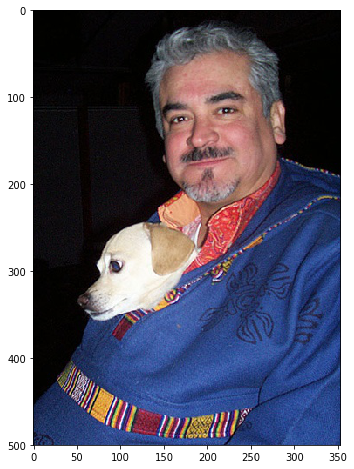

In [60]:
matplotlib.pyplot.figure(figsize=(8, 8))

target_image = skimage.io.imread(test[0]["filename"])

matplotlib.pyplot.imshow(target_image)

In [56]:
validation.shape

AttributeError: 'list' object has no attribute 'shape'

In [50]:
classes = {"nucleus": 1}

generator = ObjectDetectionGenerator()

generator = generator.flow(training, classes)

(target_bounding_boxes, target_images, target_labels, target_metadata), _ = generator.next()

In [51]:
training

KeyboardInterrupt: 